## UNSW-NB15 实验（BT-TWD + 基线）

本 Notebook 展示在 UNSW-NB15 数据集上的中度不平衡、成本敏感实验流程。

### Step 0：基础设置
- 导入依赖
- 读取 YAML 配置
- 打印关键参数

In [1]:
# 步骤0：环境与路径设置
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path  # 用于路径拼接

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 将项目根目录加入路径，便于导入 bttwdlib
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root_path not in sys.path:
    sys.path.append(root_path)

from bttwdlib import (
    load_yaml_cfg,
    show_cfg,
    load_dataset,
    prepare_features_and_labels,
    BucketTree,
    run_holdout_experiment,
    run_kfold_experiments,
    log_info,
    set_global_seed,
)

cfg_path = os.path.join(root_path, 'configs', 'unsw_nb15.yaml')
cfg = load_yaml_cfg(cfg_path)
set_global_seed(cfg.get('SEED', {}).get('global_seed', 42))
log_info('【步骤0摘要】环境准备完毕，路径与随机种子已设置。')


【INFO】【2025-11-30 18:30:34】【配置加载】已读取 e:\yan\组\三支决策\机器学习\BT_TWD\configs\unsw_nb15.yaml
【INFO】【2025-11-30 18:30:39】【步骤0摘要】环境准备完毕，路径与随机种子已设置。


### Step 1：数据加载与基本统计
- 使用显式 train/test CSV
- 查看样本分布与正负类比例

【INFO】【2025-11-30 18:30:39】【数据加载】文本表格 ..\data\UNSW-NB15\UNSW_NB15_training-set.csv 已读取，样本数=82332，列数=45
【INFO】【2025-11-30 18:30:40】【数据加载】文本表格 ..\data\UNSW-NB15\UNSW_NB15_testing-set.csv 已读取，样本数=175341，列数=45
【INFO】【2025-11-30 18:30:40】【数据加载】检测到显式 train/test 配置，训练集 n=82332，测试集 n=175341
【INFO】【2025-11-30 18:30:40】【数据集信息】名称=UNSW_NB15，样本数=257673，目标列=label，正类比例=63.91%；训练集正类比例=55.06%；测试集正类比例=68.06%
【INFO】【2025-11-30 18:30:41】【UNSW】训练集大小：82332，测试集大小：175341
【INFO】【2025-11-30 18:30:41】【UNSW】训练集正类占比：55.06%，测试集正类占比：68.06%
        dur proto service state  spkts  dpkts  sbytes  dbytes         rate  \
0  0.000011   udp       -   INT      2      0     496       0   90909.0902   
1  0.000008   udp       -   INT      2      0    1762       0  125000.0003   
2  0.000005   udp       -   INT      2      0    1068       0  200000.0051   
3  0.000006   udp       -   INT      2      0     900       0  166666.6608   
4  0.000010   udp       -   INT      2      0    2126       0  100000.0025   

   sttl  ...  ct

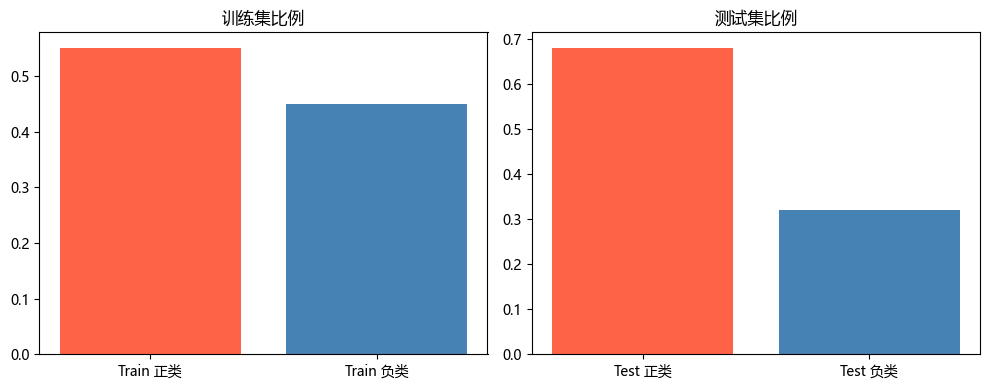

In [2]:

df_raw, target_col = load_dataset(cfg)
split_col = 'split' if 'split' in df_raw.columns else None
if split_col is None:
    raise RuntimeError('UNSW 配置要求显式 train/test 划分')

df_train = df_raw[df_raw[split_col].str.lower() == 'train'].reset_index(drop=True)
df_test = df_raw[df_raw[split_col].str.lower() == 'test'].reset_index(drop=True)

log_info(f"【UNSW】训练集大小：{len(df_train)}，测试集大小：{len(df_test)}")
pos_train = df_train[target_col].mean()
pos_test = df_test[target_col].mean()
log_info(f"【UNSW】训练集正类占比：{pos_train:.2%}，测试集正类占比：{pos_test:.2%}")

print(df_train.head())

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].bar(['Train 正类','Train 负类'], [pos_train, 1-pos_train], color=['tomato','steelblue'])
ax[0].set_title('训练集比例')
ax[1].bar(['Test 正类','Test 负类'], [pos_test, 1-pos_test], color=['tomato','steelblue'])
ax[1].set_title('测试集比例')
plt.tight_layout()
plt.show()


### Step 2：运行基线模型 (LogReg / RF / KNN / XGB)
- 使用配置中的 baselines 列表
- 统一输出关键指标 (Recall / BAC / Regret 等)

In [3]:

# 预处理训练/测试特征
X_train, y_train, meta = prepare_features_and_labels(df_train, cfg)
prep_cfg = cfg.get('PREPROCESS', {})
bucket_cols = (prep_cfg.get('continuous_cols') or []) + (prep_cfg.get('categorical_cols') or [])
bucket_df_train = df_train[bucket_cols].reset_index(drop=True)

pipeline = meta['preprocess_pipeline']
from scipy import sparse
X_test_raw = df_test.drop(columns=list(prep_cfg.get('drop_cols', [])) + [cfg['DATA']['target_col']], errors='ignore')
X_test = pipeline.transform(X_test_raw)
if sparse.issparse(X_test):
    X_test = X_test.toarray()
bucket_df_test = df_test[bucket_cols].reset_index(drop=True)

test_labels = (df_test[cfg['DATA']['target_col']] == cfg['DATA']['positive_label']).astype(int).values
test_data = (X_test, test_labels, bucket_df_test)

log_info('【UNSW】开始运行 BT-TWD 与基线模型的 5 折交叉验证实验……')
results = run_kfold_experiments(X_train, y_train, bucket_df_train, cfg, test_data=test_data)

metrics_path = Path(cfg['OUTPUT']['results_dir']) / 'metrics_overview.csv'
if metrics_path.exists():
    metrics_df = pd.read_csv(metrics_path)
    display(metrics_df.sort_values('Recall', ascending=False))
else:
    print('未找到 metrics_overview.csv，请检查运行日志。')


【INFO】【2025-11-30 18:30:41】【预处理】连续特征=0个，类别特征=3个
【INFO】【2025-11-30 18:30:41】【预处理】编码后维度=151
【INFO】【2025-11-30 18:30:41】【UNSW】开始运行 BT-TWD 与基线模型的 5 折交叉验证实验……
【INFO】【2025-11-30 18:30:41】【基线-LogReg】使用决策阈值=0.500（fixed 模式）


e:\yan\组\三支决策\机器学习\BT_TWD\bttwdlib\baselines.py:103: RuntimeWarning: Mean of empty slice
  summary[f"{col}_mean"] = float(np.nanmean(arr))
C:\Users\xzq20.HUANLI\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


【INFO】【2025-11-30 18:31:17】【基线-LogReg】整体指标：AUC_mean=0.881, AUC_std=0.003, BAC_mean=0.799, BAC_std=0.004, BND_ratio_mean=0.000, BND_ratio_std=0.000, F1_mean=0.799, F1_std=0.004, Kappa_mean=0.589, Kappa_std=0.008, MCC_mean=0.595, MCC_std=0.008, POS_Coverage_mean=nan, POS_Coverage_std=nan, Precision_mean=0.861, Precision_std=0.004, Recall_mean=0.745, Recall_std=0.004, Regret_mean=0.768, Regret_std=0.012
【INFO】【2025-11-30 18:31:17】【基线-RF】使用决策阈值=0.500（fixed 模式）


e:\yan\组\三支决策\机器学习\BT_TWD\bttwdlib\baselines.py:103: RuntimeWarning: Mean of empty slice
  summary[f"{col}_mean"] = float(np.nanmean(arr))
C:\Users\xzq20.HUANLI\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


【INFO】【2025-11-30 18:32:33】【基线-RF】整体指标：AUC_mean=0.882, AUC_std=0.003, BAC_mean=0.799, BAC_std=0.004, BND_ratio_mean=0.000, BND_ratio_std=0.000, F1_mean=0.799, F1_std=0.004, Kappa_mean=0.589, Kappa_std=0.008, MCC_mean=0.596, MCC_std=0.008, POS_Coverage_mean=nan, POS_Coverage_std=nan, Precision_mean=0.861, Precision_std=0.004, Recall_mean=0.746, Recall_std=0.004, Regret_mean=0.766, Regret_std=0.012
【INFO】【2025-11-30 18:32:33】【基线-KNN】使用决策阈值=0.500（fixed 模式）


e:\yan\组\三支决策\机器学习\BT_TWD\bttwdlib\baselines.py:103: RuntimeWarning: Mean of empty slice
  summary[f"{col}_mean"] = float(np.nanmean(arr))
C:\Users\xzq20.HUANLI\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


【INFO】【2025-11-30 18:32:48】【基线-KNN】整体指标：AUC_mean=0.757, AUC_std=0.011, BAC_mean=0.717, BAC_std=0.013, BND_ratio_mean=0.000, BND_ratio_std=0.000, F1_mean=0.718, F1_std=0.009, Kappa_mean=0.426, Kappa_std=0.026, MCC_mean=0.432, MCC_std=0.028, POS_Coverage_mean=nan, POS_Coverage_std=nan, Precision_mean=0.779, Precision_std=0.020, Recall_mean=0.665, Recall_std=0.004, Regret_mean=1.025, Regret_std=0.018
【INFO】【2025-11-30 18:32:48】【基线-XGB】使用决策阈值=0.500（fixed 模式）


C:\Users\xzq20.HUANLI\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\xzq20.HUANLI\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:32:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\xzq20.HUANLI\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:32:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



【INFO】【2025-11-30 18:33:02】【基线-XGB】整体指标：AUC_mean=0.882, AUC_std=0.003, BAC_mean=0.799, BAC_std=0.004, BND_ratio_mean=0.000, BND_ratio_std=0.000, F1_mean=0.799, F1_std=0.004, Kappa_mean=0.589, Kappa_std=0.008, MCC_mean=0.596, MCC_std=0.008, POS_Coverage_mean=nan, POS_Coverage_std=nan, Precision_mean=0.861, Precision_std=0.004, Recall_mean=0.746, Recall_std=0.004, Regret_mean=0.766, Regret_std=0.013
【INFO】【2025-11-30 18:33:02】【K折实验】正在执行第 1/5 折...
【INFO】【2025-11-30 18:33:02】[BT] 使用桶评分配置：mode=bac_regret, bac_weight=1.0, regret_weight=1.0, regret_sign=-1.0


C:\Users\xzq20.HUANLI\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:33:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


【INFO】【2025-11-30 18:33:04】【BTTWD】全局模型训练完成，用于兜底预测
[INFO][BT][2025-11-30 18:33:04] 创建桶 bucket_id=ROOT，level=0，parent_id=ROOT，split_name=ROOT，split_type=ROOT，split_rule="all"，n_samples=65865
[INFO][BT][2025-11-30 18:33:04] 创建桶 bucket_id=L1_proto=any，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="any"，n_samples=76
[INFO][BT][2025-11-30 18:33:04] 创建桶 bucket_id=L1_proto=gre，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="gre"，n_samples=76
[INFO][BT][2025-11-30 18:33:04] 创建桶 bucket_id=L1_proto=ospf，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="ospf"，n_samples=535
[INFO][BT][2025-11-30 18:33:04] 创建桶 bucket_id=L1_proto=rsvp，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="rsvp"，n_samples=52
[INFO][BT][2025-11-30 18:33:04] 创建桶 bucket_id=L1_proto=sctp，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="sctp"，n_samples=26

C:\Users\xzq20.HUANLI\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:33:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


【INFO】【2025-11-30 18:33:12】【BTTWD】全局模型训练完成，用于兜底预测
[INFO][BT][2025-11-30 18:33:12] 创建桶 bucket_id=ROOT，level=0，parent_id=ROOT，split_name=ROOT，split_type=ROOT，split_rule="all"，n_samples=65865
[INFO][BT][2025-11-30 18:33:12] 创建桶 bucket_id=L1_proto=any，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="any"，n_samples=78
[INFO][BT][2025-11-30 18:33:12] 创建桶 bucket_id=L1_proto=gre，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="gre"，n_samples=67
[INFO][BT][2025-11-30 18:33:12] 创建桶 bucket_id=L1_proto=ipv6，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="ipv6"，n_samples=52
[INFO][BT][2025-11-30 18:33:12] 创建桶 bucket_id=L1_proto=ospf，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="ospf"，n_samples=543
[INFO][BT][2025-11-30 18:33:12] 创建桶 bucket_id=L1_proto=sctp，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="sctp"，n_samples=25

C:\Users\xzq20.HUANLI\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:33:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


【INFO】【2025-11-30 18:33:21】【BTTWD】全局模型训练完成，用于兜底预测
[INFO][BT][2025-11-30 18:33:21] 创建桶 bucket_id=ROOT，level=0，parent_id=ROOT，split_name=ROOT，split_type=ROOT，split_rule="all"，n_samples=65866
[INFO][BT][2025-11-30 18:33:21] 创建桶 bucket_id=L1_proto=any，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="any"，n_samples=79
[INFO][BT][2025-11-30 18:33:21] 创建桶 bucket_id=L1_proto=gre，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="gre"，n_samples=67
[INFO][BT][2025-11-30 18:33:21] 创建桶 bucket_id=L1_proto=ospf，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="ospf"，n_samples=550
[INFO][BT][2025-11-30 18:33:21] 创建桶 bucket_id=L1_proto=rsvp，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="rsvp"，n_samples=56
[INFO][BT][2025-11-30 18:33:21] 创建桶 bucket_id=L1_proto=sctp，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="sctp"，n_samples=26

C:\Users\xzq20.HUANLI\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:33:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


【INFO】【2025-11-30 18:33:29】【BTTWD】全局模型训练完成，用于兜底预测
[INFO][BT][2025-11-30 18:33:29] 创建桶 bucket_id=ROOT，level=0，parent_id=ROOT，split_name=ROOT，split_type=ROOT，split_rule="all"，n_samples=65866
[INFO][BT][2025-11-30 18:33:29] 创建桶 bucket_id=L1_proto=any，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="any"，n_samples=68
[INFO][BT][2025-11-30 18:33:29] 创建桶 bucket_id=L1_proto=gre，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="gre"，n_samples=73
[INFO][BT][2025-11-30 18:33:29] 创建桶 bucket_id=L1_proto=ospf，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="ospf"，n_samples=535
[INFO][BT][2025-11-30 18:33:29] 创建桶 bucket_id=L1_proto=rsvp，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="rsvp"，n_samples=52
[INFO][BT][2025-11-30 18:33:29] 创建桶 bucket_id=L1_proto=sctp，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="sctp"，n_samples=25

C:\Users\xzq20.HUANLI\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:33:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


【INFO】【2025-11-30 18:33:37】【BTTWD】全局模型训练完成，用于兜底预测
[INFO][BT][2025-11-30 18:33:38] 创建桶 bucket_id=ROOT，level=0，parent_id=ROOT，split_name=ROOT，split_type=ROOT，split_rule="all"，n_samples=65866
[INFO][BT][2025-11-30 18:33:38] 创建桶 bucket_id=L1_proto=any，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="any"，n_samples=83
[INFO][BT][2025-11-30 18:33:38] 创建桶 bucket_id=L1_proto=gre，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="gre"，n_samples=69
[INFO][BT][2025-11-30 18:33:38] 创建桶 bucket_id=L1_proto=ipv6，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="ipv6"，n_samples=51
[INFO][BT][2025-11-30 18:33:38] 创建桶 bucket_id=L1_proto=ospf，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="ospf"，n_samples=541
[INFO][BT][2025-11-30 18:33:38] 创建桶 bucket_id=L1_proto=sctp，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="sctp"，n_samples=25

C:\Users\xzq20.HUANLI\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:33:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


【INFO】【2025-11-30 18:33:46】【BTTWD】全局模型训练完成，用于兜底预测
[INFO][BT][2025-11-30 18:33:46] 创建桶 bucket_id=ROOT，level=0，parent_id=ROOT，split_name=ROOT，split_type=ROOT，split_rule="all"，n_samples=82332
[INFO][BT][2025-11-30 18:33:46] 创建桶 bucket_id=L1_proto=any，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="any"，n_samples=96
[INFO][BT][2025-11-30 18:33:46] 创建桶 bucket_id=L1_proto=gre，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="gre"，n_samples=88
[INFO][BT][2025-11-30 18:33:46] 创建桶 bucket_id=L1_proto=ipv6，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="ipv6"，n_samples=61
[INFO][BT][2025-11-30 18:33:46] 创建桶 bucket_id=L1_proto=mobile，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="mobile"，n_samples=52
[INFO][BT][2025-11-30 18:33:46] 创建桶 bucket_id=L1_proto=ospf，level=1，parent_id=ROOT，split_name=L1_proto，split_type=categorical_group，split_rule="ospf"，n_samples

C:\Users\xzq20.HUANLI\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:35:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


【INFO】【2025-11-30 18:35:28】【K折实验】所有结果已写入 results 目录
未找到 metrics_overview.csv，请检查运行日志。


### Step 3：BT-TWD 模型评估
- 桶树构建与阈值搜索
- 汇报测试集指标

In [4]:

# 直接读取上一节生成的指标表
if 'metrics_df' in locals():
    bttwd_row = metrics_df[metrics_df['model'] == 'BTTWD']
    print(bttwd_row)


### Step 4：桶结构与可解释性简析
- 输出每层桶的样本与正类比例
- 保存桶摘要至 results/unsw_nb15/buckets_summary.csv

In [5]:

bucket_metrics_path = Path(cfg['OUTPUT']['results_dir']) / 'bucket_metrics.csv'
if bucket_metrics_path.exists():
    bucket_df = pd.read_csv(bucket_metrics_path)
    print(bucket_df.head())
    out_path = Path(cfg['OUTPUT']['results_dir']) / 'buckets_summary.csv'
    bucket_df.to_csv(out_path, index=False)
    log_info(f'【BTTWD-UNSW】桶层级摘要已保存：{out_path}')
else:
    print('未找到 bucket_metrics.csv，可能需要先运行完整训练流程。')


未找到 bucket_metrics.csv，可能需要先运行完整训练流程。


### Step 5：结果小结
- BT-TWD 与基线在 Recall / BAC / Regret 上的对比
- 总结中度不平衡场景下的表现

In [6]:

if 'metrics_df' in locals():
    best_bac = metrics_df.loc[metrics_df['BAC'].idxmax()]
    print('【UNSW 小结】在测试集上 BAC 最高的模型：', best_bac['model'])
    print(metrics_df[['model','Recall','BAC','Regret']])
else:
    print('请先运行上面的实验步骤以生成指标。')


请先运行上面的实验步骤以生成指标。
